# Imports and functions

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import interpolate
from astropy import constants as const
from astropy import units as u
pd.options.mode.chained_assignment = None  # default='warn'



DIR_MODELS = 'models/'


def print_progress(current_iteration, total_iterations=100, step=10, message='Progress'): 
    '''
    Print progress
    '''
    if (current_iteration%step==0):
        print ('\r %s:  %d/%d  (%d%%)' %(message, current_iteration+1, total_iterations, 100*(current_iteration+1)/total_iterations), end='')
        
        
def reprint(message):
    print ('\r %s' %(message), end='')

    
def get_kurucz_spectral_library_params(dir_model_files, plot=False, overwrite=False):
    '''
    Reads and stores all the parameter values from all the files in 'dir_model_files'.
    '''
    output_name = DIR_MODELS + 'kurucz_spectral_library_params.csv'

    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            model_params = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')
            
    if (overwrite) or (not os.path.isfile(output_name)):
        # Get the list of all files and directories
        file_list = os.listdir(dir_model_files)

        model_params              = pd.DataFrame()
        model_params['file_name'] = file_list
        
        str_params                = model_params['file_name'].str.findall('[0-9]+|m|p')
        str_params_T              = np.array(list(map(list, zip(*str_params))))
        
        model_params['Te']        = str_params_T[2].astype(int)
        model_params['logg']      = str_params_T[3].astype(int)/10.

        # Create numerical value of metallicity (p05 --> +0.5, m02-->-0.2)
        sign               = str_params_T[0]
        conditions         = [sign == 'm', sign == 'p']
        values             = [-1*(str_params_T[1].astype(int))/10.0, (str_params_T[1].astype(int))/10.0]
        model_params['MH'] = np.select(conditions, values)

        # Saving numerical alpha values (denoted by 'a' before 't' in the file_name)
        for i, file in enumerate(file_list):
            model_params.loc[i, 'alpha']   = file[4]
        model_params['alpha'] = model_params['alpha'].str.replace('t','0.0')
        model_params['alpha'] = model_params['alpha'].str.replace('a','0.4')
        model_params['alpha'] = model_params['alpha'].astype(float)
        
        # Sort the parameters in acending order (with give order)
        model_params = model_params.sort_values(by=['alpha','Te', 'logg', 'MH'])
        model_params.reset_index(drop=True, inplace=True)

        print('Saving %s'%output_name)
        model_params.to_csv(output_name, index=False)

    if plot:
        sns.pairplot(model_params, corner=True, diag_kind="hist")

    return model_params


def get_wavelength_params(model_params, dir_model_files, output_name = 'models/wave_params.csv', plot=True, overwrite=False):
    '''
    Reads and stores limits of the wavelengths and step sizes for all files in 'model_params'.
    '''
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            df_wave_params = pd.read_csv(output_name)
            
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')
    
    if (overwrite) or (not os.path.isfile(output_name)):
        df_wave_params              = pd.DataFrame(columns=['file_name','log_wave_min','log_wave_max',
                                                            'diff_log_wave_min','diff_log_wave_med','diff_log_wave_max'])
        df_wave_params['file_name'] = model_params['file_name']

        len_model_params = len(model_params) 
        for idx in range(len_model_params):
            print_progress(idx, total_iterations=len_model_params, step=10)

            data_flux         = pd.read_csv(dir_model_files + model_params.file_name[idx],
                                            comment='#',engine='python', header=None, delim_whitespace= True,skipinitialspace=True)
            data_flux.columns = ['Wavelength', 'Flux']

            data_flux['log_Wavelength']      = np.log10(data_flux['Wavelength'])
            data_flux['diff_log_Wavelength'] = data_flux.log_Wavelength.diff()

            df_wave_params.loc[idx, 'log_wave_min']        = np.nanmin(data_flux['log_Wavelength'])
            df_wave_params.loc[idx, 'log_wave_max']        = np.nanmax(data_flux['log_Wavelength'])
            df_wave_params.loc[idx, 'diff_log_wave_min']   = np.nanmin(data_flux['diff_log_Wavelength'])
            df_wave_params.loc[idx, 'diff_log_wave_med']   = np.nanmedian(data_flux['diff_log_Wavelength'])
            df_wave_params.loc[idx, 'diff_log_wave_max']   = np.nanmax(data_flux['diff_log_Wavelength'])

        print('Saving %s'%output_name)
        df_wave_params.to_csv(output_name, index=False)

    if plot:
        sns.pairplot(df_wave_params, corner=True, diag_kind="hist")

    return df_wave_params


def combine_kurucz_spectral_library(model_params, dir_model_files, log_wave_list, debug = False, overwrite=False):
    output_name='models/kurucz_spectral_library.nc'
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            with xr.open_dataarray(output_name) as da_model:
                pass
            
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        flux_model       = pd.DataFrame()
        len_model_params = len(model_params) 

        Te_list          = model_params.Te.unique()
        logg_list        = model_params.logg.unique()
        MH_list          = model_params.MH.unique()
        alpha_list       = model_params.alpha.unique()

        wave_list = 10**log_wave_list

        for idx in range(len_model_params):
            print_progress(idx, total_iterations=len_model_params, step=10)
            data_flux         = pd.read_csv(dir_model_files + model_params.file_name[idx],comment='#',engine='python', header=None, delim_whitespace= True,skipinitialspace=True)
            data_flux.columns = ['Wavelength', 'Flux']

            # interpolate to predetermined wavelengths
            interpolater = interpolate.interp1d(data_flux.Wavelength, data_flux.Flux)
            flux_interp  = interpolater(wave_list)

            if debug:
                print(data_flux.Wavelength.min())
                plt.plot(data_flux.Wavelength, data_flux.Flux, 'o', wave_list,flux_interp, '-')
                plt.xlim(2200,2600)
                plt.ylim(10e-4, 5)
                plt.xscale('log')
                plt.yscale('log')
                plt.grid()

            if idx==0:
                nd_arr = np.empty((len(wave_list), len(Te_list), len(logg_list), len(MH_list), len(alpha_list)))
                nd_arr.fill(np.nan)

                da_model = xr.DataArray(nd_arr, coords={'Wavelength': wave_list,
                                                        'Te'        : Te_list,
                                                        'logg'      : logg_list,
                                                        'MH'        : MH_list,
                                                        'alpha'     : alpha_list})

            # add flux to given model
            da_model.loc[dict(Te   = model_params.Te[idx],
                              logg = model_params.logg[idx],
                              MH   = model_params.MH[idx],
                              alpha= model_params.alpha[idx])] = flux_interp

        da_model.attrs['unit']      = 'erg/s/cm2/A'
        da_model.attrs['long_name'] = 'Flux'

        print('Saving %s'%output_name)
        da_model.to_netcdf(file_name)
    return  da_model


def get_kurucz_synthetic_photometry_params(dir_model_files, plot=False, overwrite=False):
    output_name = DIR_MODELS + 'kurucz_synthetic_photometry_params.csv'
    
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            model_params = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        # Get the list of all files and directories
        file_list = os.listdir(dir_model_files)

        model_params              = pd.DataFrame()
        model_params['file_name'] = file_list
        str_params                = model_params['file_name'].str.findall('[0-9]+|m|p')
        str_params_T              = np.array(list(map(list, zip(*str_params))))

        model_params['Te']        = str_params_T[3].astype(int)
        model_params['logg']      = str_params_T[4].astype(int)/10.

        # create numerical value of metallicity (p05 --> +0.5, m02-->-0.2)
        sign               = str_params_T[1]
        conditions         = [sign == 'm', sign == 'p']
        values             = [-1*(str_params_T[2].astype(int))/10.0, (str_params_T[2].astype(int))/10.0]
        model_params['MH'] = np.select(conditions, values)

        # Saving numerical alpha values (denoted by 'a' before 't' in the file_name)
        for i, file in enumerate(file_list):
            model_params.loc[i, 'alpha']   = file[18]
        model_params['alpha'] = model_params['alpha'].str.replace('t','0.0')
        model_params['alpha'] = model_params['alpha'].str.replace('a','0.4')
        model_params['alpha'] = model_params['alpha'].astype(float)

        # sort the parameters in acending order (with give order)
        model_params = model_params.sort_values(by=['alpha','Te', 'logg', 'MH'])
        model_params.reset_index(drop=True, inplace=True)

        print('Saving %s'%output_name)
        model_params.to_csv(output_name, index=False)

    if plot:
        sns.pairplot(model_params, corner=True, diag_kind="hist")

    return model_params


def combine_kurucz_synthetic_photometry(model_params, dir_model_files, keep_common_filters=False, overwrite=False):
    output_name='models/kurucz_synthetic_photometry.nc'

    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            with xr.open_dataarray(output_name) as da_model:
                pass
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        flux_model       = pd.DataFrame()
        len_model_params = len(model_params) 
        Te_list          = model_params.Te.unique()
        logg_list        = model_params.logg.unique()
        MH_list          = model_params.MH.unique()
        alpha_list       = model_params.alpha.unique()

        file_name = "models/kurucz_synthetic_photometry.nc"
        print('Saving %s'%file_name)

        for idx in range(len_model_params):
            print_progress(idx, total_iterations=len_model_params, step=10)
            data_flux         = pd.read_csv(dir_model_files + model_params.file_name[idx],comment='#',engine='python', header=None, delim_whitespace= True,skipinitialspace=True)
            data_flux.columns = ['FilterID', 'Wavelength', 'Flux']
            data_flux         = data_flux.set_index('FilterID')

            if idx==0:
                data_flux   = data_flux.sort_values(by=['Wavelength'])
                data_flux   = data_flux[data_flux['Wavelength']>0]
                data_flux_0 = data_flux.copy()
                filter_list = data_flux_0.index
                wave_list   = data_flux_0['Wavelength']

                nd_arr = np.empty((len(filter_list), len(Te_list), len(logg_list), len(MH_list), len(alpha_list)))
                nd_arr.fill(np.nan)

                da_model = xr.DataArray(nd_arr, coords={'FilterID': filter_list,
                                                        'Te'      : Te_list,
                                                        'logg'    : logg_list,
                                                        'MH'      : MH_list,
                                                        'alpha'   : alpha_list})
                da_model.attrs["Wavelengths"] = wave_list.values

            if not keep_common_filters:
                if len(data_flux)!=len(data_flux_0):
                    raise Exception('ERROR: Model files have different number of filters.\n           Use "keep_common_filters=True" to use the exact filters available in the first file.\n           (sometimes, some filters are missing from the specific temperatures/logg...)')

            # keep the same filter order as the first file    
            data_flux_0['Flux_new'] = data_flux['Flux']

            # add flux to given model
            da_model.loc[dict(Te   = model_params.Te[idx],
                              logg = model_params.logg[idx],
                              MH   = model_params.MH[idx],
                              alpha= model_params.alpha[idx])] = data_flux_0['Flux_new']

        da_model.attrs['unit']      = 'erg/s/cm2/A'
        da_model.attrs['long_name'] = 'Flux'

        da_model.to_netcdf(output_name)
    return  da_model


def get_koester_spectral_library_params(dir_model_files, plot=False, overwrite=False):
    output_name = DIR_MODELS + 'koester_spectral_library_params.csv'

    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            model_params = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')
            
    if (overwrite) or (not os.path.isfile(output_name)):
        # Get the list of all files and directories
        file_list = os.listdir(dir_model_files)

        model_params              = pd.DataFrame()
        model_params['file_name'] = file_list
        
        str_params                = model_params['file_name'].str.findall('[0-9]+')
        str_params_T              = np.array(list(map(list, zip(*str_params))))
        model_params['Te']        = str_params_T[0].astype(int)
        model_params['logg']      = str_params_T[1].astype(int)/100.

        # Sort the parameters in acending order (with give order)
        model_params = model_params.sort_values(by=['Te', 'logg'])
        model_params.reset_index(drop=True, inplace=True)

        print('Saving %s'%file_name)
        model_params.to_csv(file_name, index=False)

    if plot:
        sns.pairplot(model_params, corner=True, diag_kind="hist")

    return model_params


def combine_koester_spectral_library(model_params, dir_model_files, log_wave_list, debug = False, overwrite=False):
    output_name='models/koester_spectral_library.nc'

    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            with xr.open_dataarray(output_name) as da_model:
                pass
            
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        flux_model       = pd.DataFrame()
        len_model_params = len(model_params) 

        Te_list          = model_params.Te.unique()
        logg_list        = model_params.logg.unique()

        wave_list = 10**log_wave_list

        for idx in range(len_model_params):
            print_progress(idx, total_iterations=len_model_params, step=10)
            data_flux         = pd.read_csv(dir_model_files + model_params.file_name[idx],comment='#',engine='python', header=None, delim_whitespace= True,skipinitialspace=True)
            data_flux.columns = ['Wavelength', 'Flux']

            # interpolate to predetermined wavelengths
            interpolater = interpolate.interp1d(data_flux.Wavelength, data_flux.Flux)
            flux_interp  = interpolater(wave_list)

            if debug:
                print(data_flux.Wavelength.min())
                plt.plot(data_flux.Wavelength, data_flux.Flux, 'o', wave_list,flux_interp, '-')
                plt.xlim(6550,6570)
                plt.ylim(2e6, 4e6)
                plt.xscale('log')
                plt.yscale('log')
                plt.grid()

            if idx==0:
                nd_arr = np.empty((len(wave_list), len(Te_list), len(logg_list)))
                nd_arr.fill(np.nan)

                da_model = xr.DataArray(nd_arr, coords={'Wavelength': wave_list,
                                                        'Te'        : Te_list,
                                                        'logg'      : logg_list})

            # add flux to given model
            da_model.loc[dict(Te   = model_params.Te[idx],
                              logg = model_params.logg[idx])] = flux_interp

        da_model.attrs['unit']      = 'erg/s/cm2/A'
        da_model.attrs['long_name'] = 'Flux'

        da_model.to_netcdf(file_name)
    return  da_model


def get_koester_synthetic_photometry_params(dir_model_files, plot=False, overwrite=False):
    output_name = DIR_MODELS + 'koester_synthetic_photometry_params.csv'
    
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            model_params = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):

        # Get the list of all files and directories
        file_list = os.listdir(dir_model_files)
        
        model_params              = pd.DataFrame()
        model_params['file_name'] = file_list
        str_params                = model_params['file_name'].str.findall('[0-9]+')
        str_params_T              = np.array(list(map(list, zip(*str_params))))

        model_params['Te']        = str_params_T[1].astype(int)
        model_params['logg']      = str_params_T[2].astype(int)/100.

        # sort the parameters in acending order (with give order)
        model_params = model_params.sort_values(by=['Te', 'logg'])
        model_params.reset_index(drop=True, inplace=True)

        print('Saving %s'%file_name)
        model_params.to_csv(file_name, index=False)

    if plot:
        sns.pairplot(model_params, corner=True, diag_kind="hist")

    return model_params


def combine_koester_synthetic_photometry(model_params, dir_model_files, keep_common_filters=False, overwrite=False):
    output_name='models/koester_synthetic_photometry.nc'

    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            with xr.open_dataarray(output_name) as da_model:
                pass
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        flux_model       = pd.DataFrame()
        len_model_params = len(model_params) 
        Te_list          = model_params.Te.unique()
        logg_list        = model_params.logg.unique()

        for idx in range(len_model_params):
            print_progress(idx, total_iterations=len_model_params, step=10)
            data_flux         = pd.read_csv(dir_model_files + model_params.file_name[idx],comment='#',engine='python', header=None, delim_whitespace= True,skipinitialspace=True)
            data_flux.columns = ['FilterID', 'Wavelength', 'Flux']
            data_flux         = data_flux.set_index('FilterID')

            if idx==0:
                data_flux   = data_flux.sort_values(by=['Wavelength'])
                data_flux   = data_flux[data_flux['Wavelength']>0]
                data_flux_0 = data_flux.copy()
                filter_list = data_flux_0.index
                wave_list   = data_flux_0['Wavelength']

                nd_arr = np.empty((len(filter_list), len(Te_list), len(logg_list)))
                nd_arr.fill(np.nan)

                da_model = xr.DataArray(nd_arr, coords={'FilterID': filter_list,
                                                        'Te'      : Te_list,
                                                        'logg'    : logg_list})
                da_model.attrs["Wavelengths"] = wave_list.values

            if not keep_common_filters:
                if len(data_flux)!=len(data_flux_0):
                    raise Exception('ERROR: Model files have different number of filters.\n           Use "keep_common_filters=True" to use the exact filters available in the first file.\n           (sometimes, some filters are missing from the specific temperatures/logg...)')

            # keep the same filter order as the first file    
            data_flux_0['Flux_new'] = data_flux['Flux']

            # add flux to given model
            da_model.loc[dict(Te   = model_params.Te[idx],
                              logg = model_params.logg[idx])] = data_flux_0['Flux_new']

        da_model.attrs['unit']      = 'erg/s/cm2/A'
        da_model.attrs['long_name'] = 'Flux'

        da_model.to_netcdf(output_name)
    return  da_model


def read_parsec_isochrone(file_name, skiprows=13, plot=False):
    '''
    Reads the files downloaded from parsec website
    (http://stev.oapd.inaf.it/cgi-bin/cmd) as pandas dataframe
    '''
    # Reading data
    iso = pd.read_csv(file_name, engine='python',
                      delimiter='\s+', header=None, comment='#')
    # reading column names
    _df_column_names = pd.read_csv(file_name, engine='python', delim_whitespace=True, skipinitialspace=True,
                                   skiprows=skiprows, nrows=1, header=None)
    iso_column_names = _df_column_names.drop([0], axis=1).values[0]
    # saving the column names to previously read file
    iso.columns = iso_column_names

    iso['logR'] = np.log10(calc_radius(iso['Mass'].values*u.solMass, iso['logg'].values).value)

    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.title("H R diagram")
        plt.xlabel('logL')
        plt.ylabel('logTe')
        p1 = ax.scatter(iso.logTe, iso.logL, c=iso.logAge, cmap='rainbow', s=1, marker='.')
        ax.set(title = 'HR Diagram', xlabel='log(L/L$_{\odot}$)', ylabel='log(T)')
        plt.colorbar(p1, label='log(age/yr)')
        ax.invert_xaxis()

    return iso


def get_ZAMS(MH, iso, plot_simple=False, plot_corner=False, save_plot=False):
    '''
    creating a ZAMS by combining main sequences of various ages.
        younger isochrones for high mass stars, older for low mass stars.
    '''
    if MH not in iso.MH.unique():
        # round off the MH to closest stepsize available
        _MH = MH
        MH = find_nearest(np.unique(iso.MH), MH)
        print('WARNING: Metallicity ([M/H]) rounded from %.2f to %.2f' % (_MH, MH))

    cl_iso_625 = iso[(iso.logAge == 6.25)& (iso.label < 2) & (iso.MH==MH)]
    cl_iso_65  = iso[(iso.logAge == 6.50)& (iso.label < 2) & (iso.MH==MH)]
    cl_iso_675 = iso[(iso.logAge == 6.75)& (iso.label < 2) & (iso.MH==MH)]
    cl_iso_7   = iso[(iso.logAge == 7.00)& (iso.label < 2) & (iso.MH==MH)]
    cl_iso_75  = iso[(iso.logAge == 7.50)& (iso.label < 2) & (iso.MH==MH)]
    cl_iso_8   = iso[(iso.logAge == 8.00)& (iso.label < 2) & (iso.MH==MH)]

    ZAMS_625   = cl_iso_625[(cl_iso_625.logL < 5.6) & (cl_iso_625.logL >= 3.5)]
    ZAMS_65    = cl_iso_65[  (cl_iso_65.logL < 3.5) &  (cl_iso_65.logL >= 3.0)]
    ZAMS_675   = cl_iso_675[(cl_iso_675.logL < 3.0) & (cl_iso_675.logL >= 2.5)]
    ZAMS_7     = cl_iso_7[    (cl_iso_7.logL < 2.5) &   (cl_iso_7.logL >= 1.4)]
    ZAMS_75    = cl_iso_75[  (cl_iso_75.logL < 1.4) &  (cl_iso_75.logL >= 0.9)]
    ZAMS_8     = cl_iso_8[    (cl_iso_8.logL < 0.9)]

    ZAMS = pd.concat([ZAMS_625, ZAMS_65, ZAMS_675, ZAMS_7, ZAMS_75, ZAMS_8])

    if plot_simple:
        '''
        plotting HR diagram and M-L relation showing ZAMS
        '''
        color_list = plt.cm.gist_ncar(np.linspace(0, 1, 7))  # creates array of N colors

        fig, ax = plt.subplots(figsize=(20, 10), ncols=2)

        for idx, cl_iso in enumerate([cl_iso_625, cl_iso_65, cl_iso_675, cl_iso_7, cl_iso_75, cl_iso_8]):
            ax[0].scatter(cl_iso.logTe, cl_iso.logL, color=color_list[idx],
                          s=3, label='LogAge ' + str(cl_iso.logAge.iloc[0]))
            ax[1].scatter(cl_iso.Mass, cl_iso.logL, color=color_list[idx], s=3)

        for idx, cl_ZAMS in enumerate([ZAMS_625, ZAMS_65, ZAMS_675, ZAMS_7, ZAMS_75, ZAMS_8]):
            ax[0].plot(cl_ZAMS.logTe, cl_ZAMS.logL,
                       color=color_list[idx], lw=5)
            ax[1].plot(cl_ZAMS.Mass, cl_ZAMS.logL, color=color_list[idx], lw=5)

        ax[0].set_ylim(-2, 7)
        ax[0].set_xlim(4.75, 3.6)
        ax[0].legend()
        ax[1].set_xscale('log')
        ax[0].set(title='MH = '+str(MH), xlabel='logTe', ylabel='logL')
        ax[1].set(xlabel='Mass', ylabel='logL')

        for axes in ax.ravel():
            axes.axhline(0.9, c='0.8')
            axes.axhline(1.4, c='0.8')
            axes.axhline(2.5, c='0.8')
            axes.axhline(3.0, c='0.8')
            axes.axhline(3.5, c='0.8')
            axes.axhline(5.6, c='0.8')
        if save_plot:
            plt.savefig('plots/calibration/simple_ZAMS_MH'+str(MH) +
                        '.jpg', format='jpg', dpi=300, bbox_inches='tight')
            plt.close()

    if plot_corner:
        '''
        plotting corner plot of important parameters
        '''
        ZAMS_reduced = ZAMS[['logTe', 'logL','Mass', 'logg', 'logR', 'logAge']]
        # Converting age to string which is used as 'label'
        ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
        # Converting Mass to logM
        ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])
        ZAMS_reduced.columns = ['logTe', 'logL','logM', 'logg', 'logR', 'logAge']

        sns.pairplot(ZAMS_reduced, hue="logAge", corner=True, diag_kind="hist",
                     palette="nipy_spectral", diag_kws={'alpha': 0.55, 'bins': 30})
        plt.title('ZAMS of MH = '+str(MH))

        if save_plot:
            plt.savefig('plots/calibration/cornerplot_ZAMS_MH'+str(MH) +
                        '.jpg', format='jpg', dpi=300, bbox_inches='tight')
            plt.close()

    return ZAMS


def calc_radius(M,logg):
    '''
    Calculate logg from mass and radius

    Parameters
    ----------
    mass :  Quantity or list
        mass
    logg : float or list
        logg [log of cm/s2]
    Returns
    -------
    radius : Quantity or list
        radius
    '''    
    g=10**logg * u.cm/u.s**2
    R=((const.G*M)/g)**0.5
    return R.to(u.solRad)

# Kurucz models

## Spectral library

### Checking parameter space of the models

Reading models/kurucz_spectral_library_params.csv


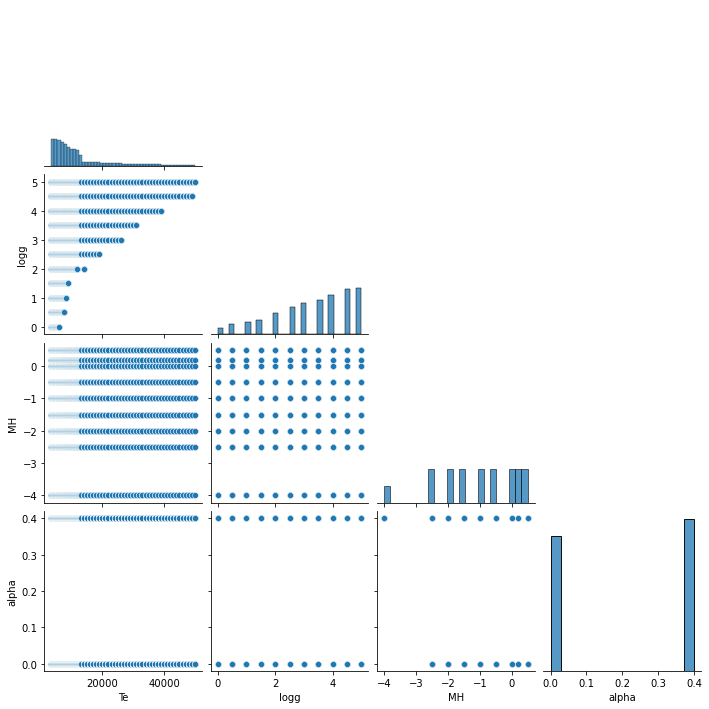

In [17]:
dir_model_files = 'models/Kurucz_spectra/'
kurucz_spectral_library_params = get_kurucz_spectral_library_params(dir_model_files, plot=True, overwrite=False)

#### Checking the spacing and limits of the wavelength axis

 Progress:  8091/8092  (99%)Saving models/kurucz_spectral_library_wave_params.csv


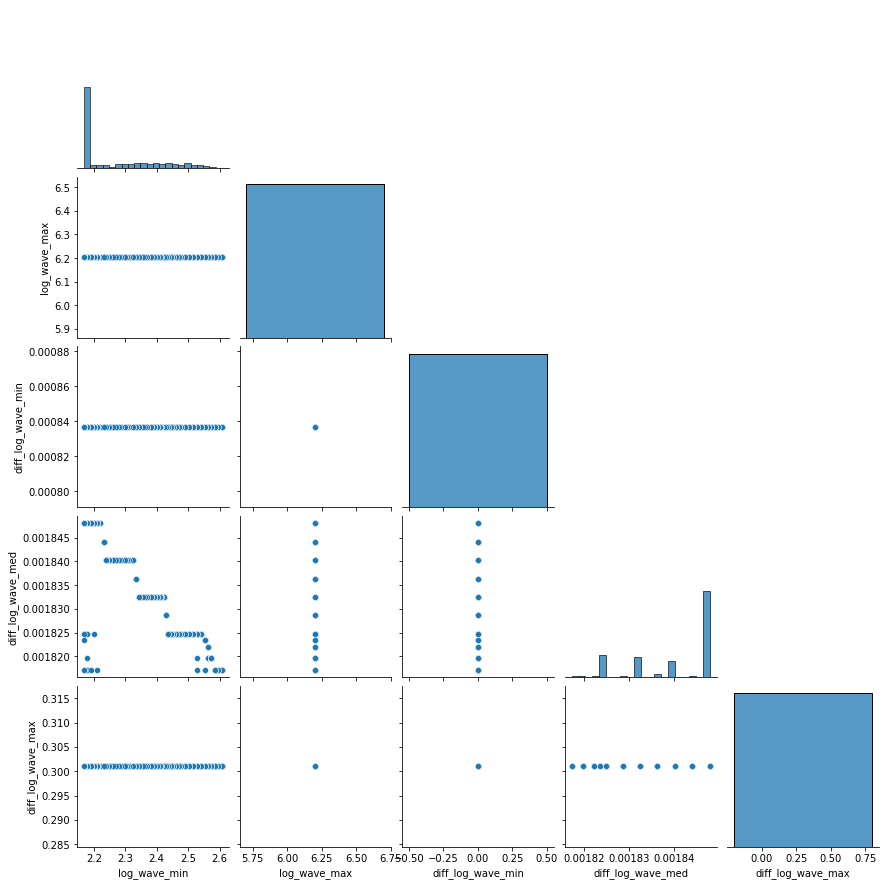

In [34]:
model_params    = kurucz_spectral_library_params
dir_model_files = 'models/Kurucz_spectra/'

df_wave_params  = get_wavelength_params(model_params[:], dir_model_files, 
                                        output_name = 'models/kurucz_spectral_library_wave_params.csv', plot=True, overwrite=False)

In [50]:
print('          diff_min   diff_med   diff_max   wave_min   wave_max')
print('Actual :  %.6f   %.6f   %.6f   %.6f   %.6f'%(np.nanmin(df_wave_params['diff_log_wave_min']),  np.nanmin(df_wave_params['diff_log_wave_med']), np.nanmax(df_wave_params['diff_log_wave_max']),
                                                  np.nanmax(df_wave_params['log_wave_min']),np.nanmin(df_wave_params['log_wave_max'])))
# ~median/4
# log_wave_diff = 0.0005
# log_wave_min  = 2.6075
# log_wave_max  = 6.2040
# ~median/2
log_wave_diff = 0.001
log_wave_min  = 2.608
log_wave_max  = 6.205
print('Rounded:             %.6f              %.6f   %.6f'%(log_wave_diff, log_wave_min,log_wave_max))

log_wave_list = np.arange(log_wave_min, log_wave_max,log_wave_diff)
print('Wavelength steps:  ', log_wave_list)

          diff_min   diff_med   diff_max   wave_min   wave_max
Actual :  0.000837   0.001817   0.301030   2.607455   6.204120
Rounded:             0.001000              2.608000   6.205000
Wavelength steps:   [2.608 2.609 2.61  ... 6.202 6.203 6.204]


### Combining spectra into single file

In [60]:
model_params = kurucz_spectral_library_params
# model_params = model_params[(model_params.Te<5500) & (model_params.logg>4.50)]
# model_params.reset_index(drop=True, inplace=True)

dir_model_files  = 'models/Kurucz_spectra/'
da_model = combine_kurucz_spectral_library(model_params,dir_model_files, log_wave_list)
da_model

Reading models/kurucz_spectral_library.nc


<xarray.DataArray (Wavelength: 3597, Te: 76, logg: 11, MH: 9, alpha: 2)>
[54127656 values with dtype=float64]
Coordinates:
  * Wavelength  (Wavelength) float64 405.5 406.4 407.4 ... 1.596e+06 1.6e+06
  * Te          (Te) int64 3500 3750 4000 4250 4500 ... 47000 48000 49000 50000
  * logg        (logg) float64 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * MH          (MH) float64 -2.5 -2.0 -1.5 -1.0 -0.5 0.0 0.2 0.5 -4.0
  * alpha       (alpha) float64 0.0 0.4
Attributes:
    unit:       erg/s/cm2/A
    long_name:  Flux

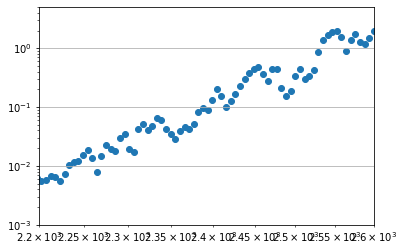

In [57]:
# Testing if the da_model worked
flux = da_model.sel(Te=3500).sel(logg=0.0).sel(MH=-2.0).sel(alpha=0.0)
plt.scatter(da_model.Wavelength, flux)
plt.xlim(2200,2600); plt.ylim(10e-4, 5); plt.xscale('log'); plt.yscale('log'); plt.grid()

## Synthetic photometry

### Checking the parameter space of the models

Reading models/kurucz_synthetic_photometry_params.csv


,file_name,Te,logg,MH,alpha
0,Kurucz2003all_fm25t3500g00k2odfnew.fl.phot.dat,3500,0.0,-2.5,0.0
1,Kurucz2003all_fm20t3500g00k2odfnew.fl.phot.dat,3500,0.0,-2.0,0.0
2,Kurucz2003all_fm15t3500g00k2odfnew.fl.phot.dat,3500,0.0,-1.5,0.0
3,Kurucz2003all_fm10t3500g00k2odfnew.fl.phot.dat,3500,0.0,-1.0,0.0
4,Kurucz2003all_fm05t3500g00k2odfnew.fl.phot.dat,3500,0.0,-0.5,0.0
...,...,...,...,...,...
8087,Kurucz2003all_fm10at50000g50k2odfnew.fl.phot.dat,50000,5.0,-1.0,0.4
8088,Kurucz2003all_fm05at50000g50k2odfnew.fl.phot.dat,50000,5.0,-0.5,0.4
8089,Kurucz2003all_fp00at50000g50k2odfnew.fl.phot.dat,50000,5.0,0.0,0.4
8090,Kurucz2003all_fp02at50000g50k2odfnew.fl.phot.dat,50000,5.0,0.2,0.4


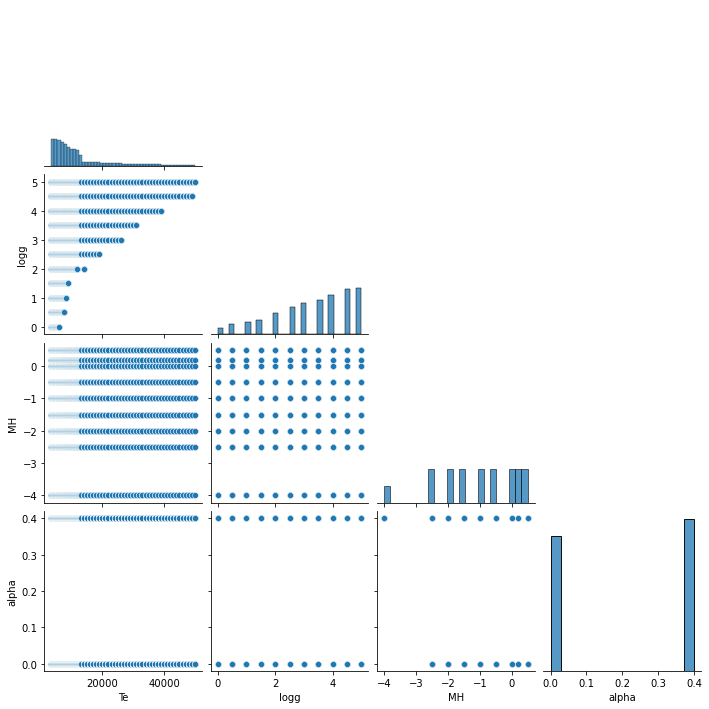

In [59]:
dir_model_files  = 'C:/Users/Zert W/Desktop/python/Synthetic_photometry_models/Kurucz_synthetic_photometry/'
kurucz_synthetic_photometry_params = get_kurucz_synthetic_photometry_params(dir_model_files, plot=True)
kurucz_synthetic_photometry_params

### Combining synthetic photometry into single file

In [62]:
model_params = kurucz_synthetic_photometry_params
# model_params = model_params[(model_params.Te<5500) & (model_params.logg>4.50)]
# model_params.reset_index(drop=True, inplace=True)

dir_model_files  = 'C:/Users/Zert W/Desktop/python/Synthetic_photometry_models/Kurucz_synthetic_photometry/'

da_model = combine_kurucz_synthetic_photometry(model_params,dir_model_files, keep_common_filters=True)
da_model

Reading models/kurucz_synthetic_photometry.nc


<xarray.DataArray (FilterID: 8147, Te: 76, logg: 11, MH: 9, alpha: 2)>
[122596056 values with dtype=float64]
Coordinates:
  * FilterID  (FilterID) object 'IUE/IUE.1250-1300' ... 'QUIJOTE/MFI.11GHz_H3'
  * Te        (Te) int32 3500 3750 4000 4250 4500 ... 47000 48000 49000 50000
  * logg      (logg) float64 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * MH        (MH) float64 -2.5 -2.0 -1.5 -1.0 -0.5 0.0 0.2 0.5 -4.0
  * alpha     (alpha) float64 0.0 0.4
Attributes:
    Wavelengths:  [1.28470318e+03 1.35336435e+03 1.35623969e+03 ... 3.8683349...
    unit:         erg/s/cm2/A
    long_name:    Flux

# Koester models

## Spectral library

### Checking the parameter space of the models

Reading models/koester_spectral_library_params.csv


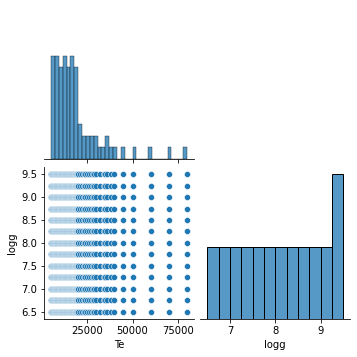

In [63]:
dir_model_files = 'models/Koester_spectra/'
koester_spectral_library_params = get_koester_spectral_library_params(dir_model_files, plot=True)

#### Checking the spacing and limits of the wavelength axis

Reading models/koester_spectral_library_wave_params.csv


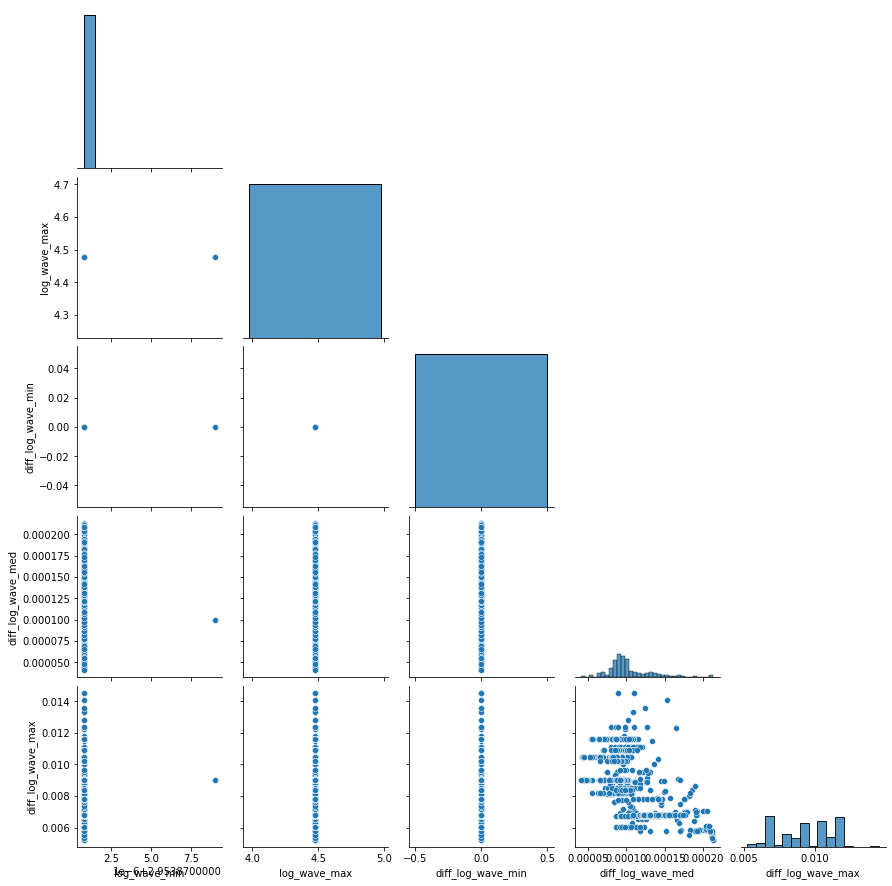

In [65]:
model_params = koester_spectral_library_params
dir_model_files = 'models/Koester_spectra/'

df_wave_params = get_wavelength_params(model_params[:], dir_model_files, 
                                       output_name = 'models/koester_spectral_library_wave_params.csv')


In [68]:
print('          diff_min   diff_med   diff_max   wave_min   wave_max')
print('Actual :  %.6f   %.6f   %.6f   %.6f   %.6f'%(np.nanmin(df_wave_params['diff_log_wave_min']),  np.nanmin(df_wave_params['diff_log_wave_med']), np.nanmax(df_wave_params['diff_log_wave_max']),
                                                  np.nanmax(df_wave_params['log_wave_min']),np.nanmin(df_wave_params['log_wave_max'])))

log_wave_diff = 0.001
log_wave_min  = 2.954
log_wave_max  = 4.477
print('Rounded:             %.6f              %.6f   %.6f'%(log_wave_diff, log_wave_min,log_wave_max))

log_wave_list = np.arange(log_wave_min, log_wave_max,log_wave_diff)
print('Wavelength steps:  ', log_wave_list)

          diff_min   diff_med   diff_max   wave_min   wave_max
Actual :  0.000000   0.000041   0.014512   2.953879   4.477003
Rounded:             0.001000              2.954000   4.477000
Wavelength steps:   [2.954 2.955 2.956 ... 4.474 4.475 4.476]


### Combining spectra into single file

In [70]:
model_params = koester_spectral_library_params
# model_params = model_params[(model_params.Te<5500) & (model_params.logg>4.50)]
# model_params.reset_index(drop=True, inplace=True)

dir_model_files  = 'models/Koester_spectra/'
da_model = combine_koester_spectral_library(model_params[:],dir_model_files, log_wave_list)
da_model

Reading models/koester_spectral_library.nc


<xarray.DataArray (Wavelength: 1523, Te: 82, logg: 13)>
[1623518 values with dtype=float64]
Coordinates:
  * Wavelength  (Wavelength) float64 899.5 901.6 903.6 ... 2.985e+04 2.992e+04
  * Te          (Te) int64 5000 5250 5500 5750 6000 ... 50000 60000 70000 80000
  * logg        (logg) float64 6.5 6.75 7.0 7.25 7.5 ... 8.5 8.75 9.0 9.25 9.5
Attributes:
    unit:       erg/s/cm2/A
    long_name:  Flux

## Syntehtic photometry

### Checking the parameter space of the models

Reading models/koester_synthetic_photometry_params.csv


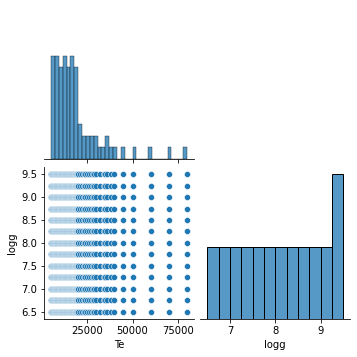

In [71]:
dir_model_files  = 'C:/Users/Zert W/Desktop/python/Synthetic_photometry_models/Koester_synthetic_photometry/'
koester_synthetic_photometry_params = get_koester_synthetic_photometry_params(dir_model_files, plot=True)

### Combining synthetic photometry into single file

In [73]:
model_params = koester_synthetic_photometry_params
# model_params = model_params[(model_params.Te<7500) & (model_params.logg<7.50)]
# model_params.reset_index(drop=True, inplace=True)

dir_model_files  = 'C:/Users/Zert W/Desktop/python/Synthetic_photometry_models/Koester_synthetic_photometry/'

da_model = combine_koester_synthetic_photometry(model_params,dir_model_files, keep_common_filters=True)
da_model

Reading models/koester_synthetic_photometry.nc


<xarray.DataArray (FilterID: 8102, Te: 82, logg: 13)>
[8636732 values with dtype=float64]
Coordinates:
  * FilterID  (FilterID) object 'IUE/IUE.1250-1300' ... 'QUIJOTE/MFI.11GHz_H3'
  * Te        (Te) int64 5000 5250 5500 5750 6000 ... 50000 60000 70000 80000
  * logg      (logg) float64 6.5 6.75 7.0 7.25 7.5 ... 8.5 8.75 9.0 9.25 9.5
Attributes:
    Wavelengths:  [1.28470318e+03 1.35608150e+03 1.35899193e+03 ... 3.8683349...
    unit:         erg/s/cm2/A
    long_name:    Flux

# master_ZAMS

Available metallicities, [M/H] : 
         [-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7
 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2]
Available log(age/yr) : 
         [ 6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]


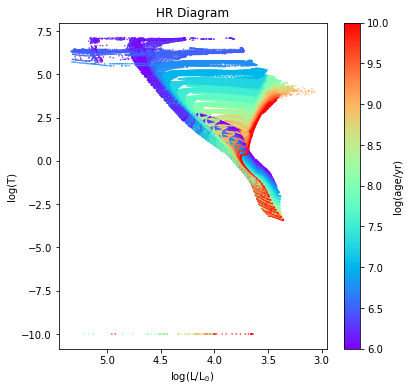

In [2]:
iso_file_name = DIR_MODELS+'isochrone_GaiaEDR3_logAge6-10_MH-2-0.2.dat'
iso = read_parsec_isochrone(iso_file_name, plot=True)
print('Available metallicities, [M/H] : \n        ',iso.MH.unique())
print('Available log(age/yr) : \n        ', iso.logAge.unique())

## Plotting ZAMS and testing continuity for all metallicities

In [32]:
for idx, MH in enumerate(iso.MH.unique()[:]):
    print(MH)
    ZAMS_temp = get_ZAMS(MH,iso,plot_simple=True, plot_corner=True, save_plot=True)

-2.0


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.9


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.8


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.7


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.6


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.5


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.4


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.3


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.2


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.1


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-1.0


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.9


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.8


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.7


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.6


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.5


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.4


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.3


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.2


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


-0.1


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


0.0


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


0.1


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


0.2


C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['logAge'] = ZAMS_reduced['logAge'].astype(str)
C:\Users\Zert W\AppData\Local\Temp\ipykernel_13536\1809152771.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ZAMS_reduced['Mass'] = np.log10(ZAMS_reduced['Mass'])


## Saving ZAMS of all metallicities as one file

Reading models/master_ZAMS.csv


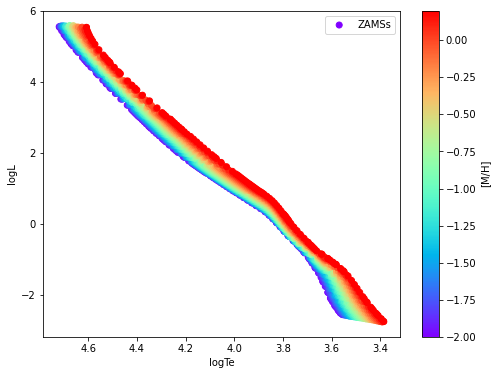

In [46]:
def get_master_ZAMS(iso, plot=False, overwrite=False):
    output_name = 'models/master_ZAMS.csv'
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            master_ZAMS = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):
        master_ZAMS = pd.DataFrame()
        for idx, MH in enumerate(iso.MH.unique()[:]):
            
            ZAMS_temp = get_ZAMS(MH,iso)
            if idx==0:
                master_ZAMS=ZAMS_temp
            else: 
                master_ZAMS=pd.concat([master_ZAMS, ZAMS_temp])
            print(MH, len(ZAMS_temp), len(master_ZAMS))

        master_ZAMS.to_csv(output_name, index=False)
    if plot:
        fig, ax = plt.subplots(figsize =(8,6))
        p0 = ax.scatter(master_ZAMS.logTe, master_ZAMS.logL, c=master_ZAMS.MH, cmap='rainbow', label='ZAMSs')
        plt.colorbar(p0, label='[M/H]')
        ax.invert_xaxis()
        ax.legend()
        ax.set(xlabel='logTe',ylabel='logL')
    return master_ZAMS

master_ZAMS = get_master_ZAMS(iso, plot=True)

# master_isochrone

Available metallicities, [M/H] : 
         [-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7
 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2]
Available log(age/yr) : 
         [ 6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]


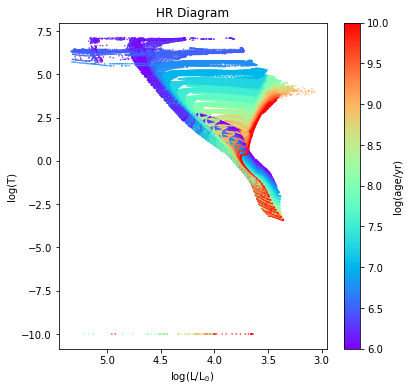

In [3]:
iso_file_name = DIR_MODELS+'isochrone_GaiaEDR3_logAge6-10_MH-2-0.2.dat'
iso = read_parsec_isochrone(iso_file_name, plot=False)
print('Available metallicities, [M/H] : \n        ',iso.MH.unique())
print('Available log(age/yr) : \n        ', iso.logAge.unique())

In [16]:
iso_7 = iso[(iso.logAge==7.0) & (iso.MH==0.0) & (iso.label<3.5)]
iso_8 = iso[(iso.logAge==8.0) & (iso.MH==0.0) & (iso.label<3.5)]
iso_9 = iso[(iso.logAge==9.0) & (iso.MH==0.0) & (iso.label<3.5)]
iso_10 = iso[(iso.logAge==10.0) & (iso.MH==0.0) & (iso.label<3.5)]

master_iso=pd.concat([iso_7,iso_8,iso_9,iso_10])
print(master_iso.columns)
master_iso[['MH', 'logAge', 'Mini', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag', 'logR']].to_csv('models/master_isochrone.csv', index=False)


Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag', 'logR'],
      dtype='object')


# Bergeron WD models

In [5]:
def read_Bergeron_WD_cooling_curve(WD_mass, spectral_type='DA'):
    if spectral_type == 'DA':
        WD_file_name = DIR_models + 'WD_cooling_curves/Table_Mass_'+WD_mass
    if spectral_type == 'DB':
        WD_file_name = DIR_models + 'WD_cooling_curves/Table_Mass_'+WD_mass + '.DB'

    df = pd.read_csv(WD_file_name, engine='python',
                     delimiter='\s+', skiprows=1, header=None)
    df.columns = ['Teff', 'logg', 'Mbol', 'BC', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'Ks', 'Y', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4', 'S3.6',
                  'S4.5', 'S5.8', 'S8.0', 'u', 'g', 'r', 'i', 'z', 'g', 'r', 'i', 'z', 'y', 'G2', 'G2_BP', 'G2_RP', 'G3', 'G3_BP', 'G3_RP', 'FUV', 'NUV', 'Age']
    df['logL'] = ((4.8-df['Mbol'])/2.5)
    df['mass'] = float(WD_mass)
    df['spectral_type'] = spectral_type
    
    return df


DIR_models= 'models_individual/'

WD_Bergeron_model = read_Bergeron_WD_cooling_curve('0.5', spectral_type='DA')

Reading models/master_Bergeron_WD.csv


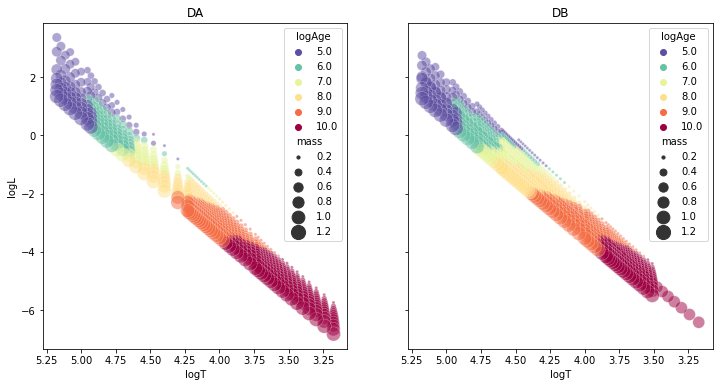

In [66]:
def get_Bergeron_model(overwrite=False, plot=False):
    output_name = 'models/master_Bergeron_WD.csv'
    # If the model_params file exists, it will be read
    if os.path.isfile(output_name): 
        if not overwrite:
            print('Reading %s'%output_name)
            master_Bergeron_model = pd.read_csv(output_name)
        if overwrite: 
            print('WARNING: '+output_name+' file will be overwritten.')

    if (overwrite) or (not os.path.isfile(output_name)):

        WD_mass_list = (np.round(np.arange(0.2, 1.3, 0.1),1)).astype(str)

        master_Bergeron_model = pd.DataFrame()
        for WD_mass in WD_mass_list:
            for spectral_type in ['DA','DB']:
                reprint([WD_mass, spectral_type])
                _model = read_Bergeron_WD_cooling_curve(WD_mass, spectral_type)
                master_Bergeron_model = pd.concat([master_Bergeron_model,_model])
        master_Bergeron_model.reset_index(drop=True, inplace=True)
        
        print('Saving %s'%output_name)
        master_Bergeron_model.to_csv(output_name, index=False)

    if plot:
        _model = master_Bergeron_model.copy()
        _model['logAge'] = np.round(np.log10(np.select([(_model['Age']<1e5)], [1e5], _model['Age'])))
        _model['logT'] = np.log10(_model['Teff'])
        DA = _model[_model.spectral_type=='DA']
        DB = _model[_model.spectral_type=='DB']
        
        fig, ax = plt.subplots(figsize =(12,6), ncols=2, sharex=True, sharey=True)
        sns.scatterplot(x='logT', y='logL', hue='logAge', size='mass',
                    sizes=(10, 200), alpha=.5, palette="Spectral_r",
                    data=DA, ax=ax[0])
        sns.scatterplot(x='logT', y='logL', hue='logAge', size='mass',
                    sizes=(10, 200), alpha=.5, palette="Spectral_r",
                    data=DB, ax=ax[1])

        ax[0].invert_xaxis()
        ax[0].set_title('DA')
        ax[1].set_title('DB')
    return master_Bergeron_model
            
master_Bergeron_model = get_Bergeron_model(overwrite=False, plot=True)